In [16]:
import numpy as np
import anndata
from src import preprocess, get_hg_reduction, reduce, scatterplot, knn_auto
import matplotlib.pyplot as plt
import igraph as ig
import leidenalg as la
import seaborn as sns
from sklearn.metrics import adjusted_rand_score as ARI

In [2]:
adata = anndata.read_h5ad("data/romanov_brain.h5ad")

In [3]:
adata = preprocess(
    adata,
    filter_genes=True,
    normalize=True,
    log1p=True,
    high_var=True,
    scale=True,
)

adata has shape (2881, 24341)


/Users/ehasanaj/miniconda3/envs/ml38/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (2881, 3729)


<h2>Get hypergraph reduction</h2>

In [4]:
# this is sparse
reduced_adj = get_hg_reduction(adata.X, n_clusters=4)
print(f"Adjacency matrix has shape {reduced_adj.shape}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3729/3729 [04:12<00:00, 14.76it/s]


Adjacency matrix has shape (2881, 2881)


In [5]:
order = np.argsort(adata.obs['labels']) # cells ordered so we can see blocks in the heatmap

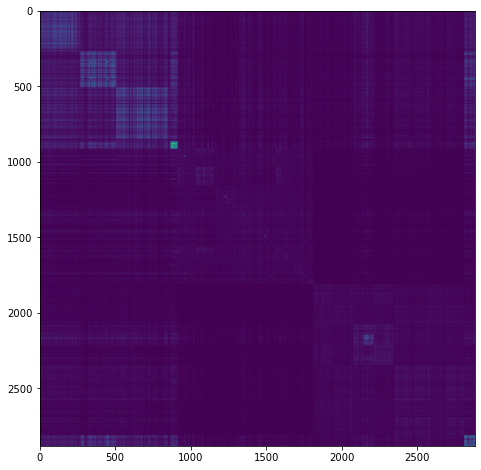

In [6]:
fig, ax = plt.subplots()
#ax.imshow(reduced_adj.todense()[order][:, order])
ax.imshow(np.log(reduced_adj.todense()[order][:, order] + 1)) # careful with dense
fig.set_size_inches((8, 8))
plt.show()

<h2>Construct graph using reduced adj</h2>

In [5]:
sources, targets = reduced_adj.nonzero()
weights = np.array(reduced_adj[sources, targets])

In [6]:
gg = ig.Graph(directed=False)
gg.add_vertices(adata.shape[0]) # cells
gg.add_edges(list(zip(list(sources), list(targets))))

<h4>Leiden</h4>

In [7]:
part = la.find_partition(
    gg,
    la.RBConfigurationVertexPartition,
    weights=weights.flatten(),
    resolution_parameter=1,
)
predictions_reduced_hg = np.array(part.membership, dtype=int)

<h2>Construct graph using KNN</h2>

In [8]:
sources_base, targets_base, weights_base = knn_auto(adata.X)

In [9]:
gg_base = ig.Graph(directed=False)
gg_base.add_vertices(adata.shape[0]) # cells
gg_base.add_edges(list(zip(list(sources_base), list(targets_base))))

<h4>Leiden</h4>

In [10]:
part_base = la.find_partition(
    gg_base,
    la.RBConfigurationVertexPartition,
    #weights=weights_base.flatten(),  # dont use weights here
    resolution_parameter=1,
)
predictions_base = np.array(part_base.membership, dtype=int)

<h2>Score</h2>

In [11]:
score_reduced = ARI(predictions_reduced_hg, adata.obs['annotations'])
score_base = ARI(predictions_base, adata.obs['annotations'])
print("Hypergraph method score:", score_reduced)
print("KNN method score:", score_base)

Hypergraph method score: 0.721098616314847
KNN method score: 0.4889272569961462


<h2>Visualize</h2>

In [12]:
# best to run this once and save the new adata object
# with the embeddings stored in it.
# Be careful about what preprocessing you applied
# to which dataset
reduce(adata) # adds 2d embeddings

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


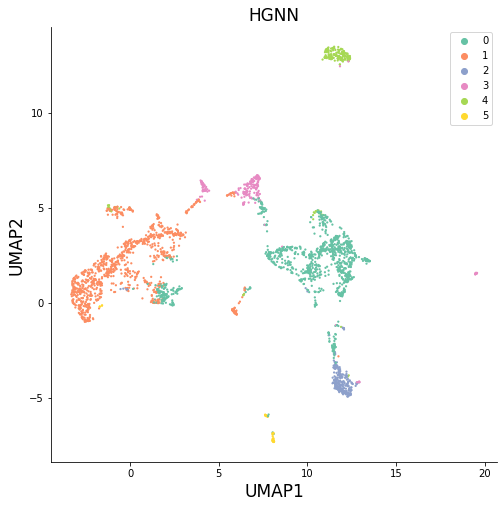

In [28]:
ax = sns.scatterplot(
    x=adata.obsm['x_emb_2d'][:, 0],
    y=adata.obsm['x_emb_2d'][:, 1],
    hue=predictions_reduced_hg,
    palette='Set2',
    linewidth=0,
    s=5,
)

ax.figure.set_size_inches((8, 8))
sns.despine(ax=ax)
ax.set_xlabel('UMAP1', fontsize=17)
ax.set_ylabel('UMAP2', fontsize=17)
ax.set_title('HGNN', fontsize=17)

plt.savefig('output/hgnn_romanov.png', dpi=300, transparent=True)

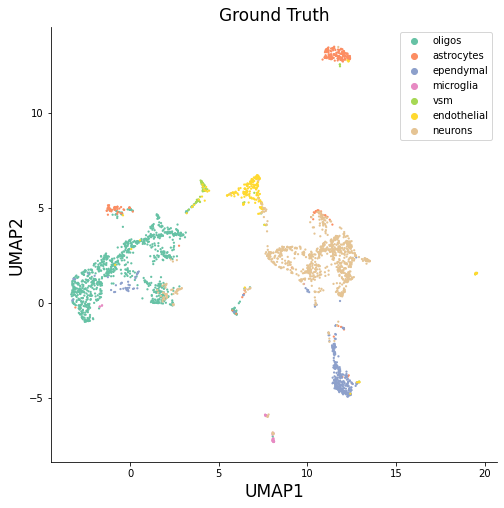

In [31]:
ax = sns.scatterplot(
    x=adata.obsm['x_emb_2d'][:, 0],
    y=adata.obsm['x_emb_2d'][:, 1],
    hue=adata.obs['annotations'].to_numpy(),
    palette='Set2',
    linewidth=0,
    s=5,
)

ax.figure.set_size_inches((8, 8))
sns.despine(ax=ax)
ax.set_xlabel('UMAP1', fontsize=17)
ax.set_ylabel('UMAP2', fontsize=17)
ax.set_title('Ground Truth', fontsize=17)

plt.savefig('output/gt_romanov.png', dpi=300, transparent=True)

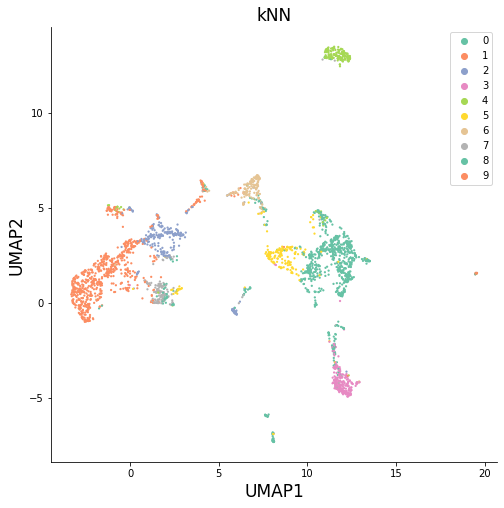

In [32]:
ax = sns.scatterplot(
    x=adata.obsm['x_emb_2d'][:, 0],
    y=adata.obsm['x_emb_2d'][:, 1],
    hue=predictions_base,
    palette='Set2',
    linewidth=0,
    s=5,
)

ax.figure.set_size_inches((8, 8))
sns.despine(ax=ax)
ax.set_xlabel('UMAP1', fontsize=17)
ax.set_ylabel('UMAP2', fontsize=17)
ax.set_title('kNN', fontsize=17)

plt.savefig('output/knn_romanov.png', dpi=300, transparent=True)